In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install tensorboard_logger

!cp "/content/drive/MyDrive/DCC Codes/config.py" .
!cp "/content/drive/MyDrive/DCC Codes/edgeConstruction.py" .
!cp "/content/drive/MyDrive/DCC Codes/data_params.py" .
!cp "/content/drive/MyDrive/DCC Codes/make_data.py" .
!cp "/content/drive/MyDrive/DCC Codes/pretraining.py" .
!cp "/content/drive/MyDrive/DCC Codes/extract_feature.py" .
!cp "/content/drive/MyDrive/DCC Codes/copyGraph.py" .
!cp "/content/drive/MyDrive/DCC Codes/DCC.py" .
!cp "/content/drive/MyDrive/DCC Codes/extractSDAE.py" .
!cp "/content/drive/MyDrive/DCC Codes/extractconvSDAE.py" .
!cp "/content/drive/MyDrive/DCC Codes/SDAE.py" .
!cp "/content/drive/MyDrive/DCC Codes/__init__.py" .
!cp "/content/drive/MyDrive/DCC Codes/DCCComputation.py" .
!cp "/content/drive/MyDrive/DCC Codes/DCCLoss.py" .
!cp "/content/drive/MyDrive/DCC Codes/custom_data.py" .
!cp "/content/drive/MyDrive/DCC Codes/convSDAE.py" .

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
import numpy as np
import pandas as pd
from scipy.io import loadmat

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from config import cfg, get_data_dir
from easydict import EasyDict as edict
from edgeConstruction import compressed_data
from custom_data import DCCPT_data
import data_params as dp
import make_data
import pretraining
import extract_feature
import copyGraph
import DCC

In [10]:
#some necessary initial functions

def set_pretraining_hypers(args):
  args.db = dp.oyster.name
  args.niter = 500
  args.step = 300
  args.lr = 0.001

# if we need to resume for faster debugging/results
  args.resume = False
  args.level = None

  args.batchsize = 300
  args.ngpu = 0
  args.deviceID = 0
  args.tensorboard = True
  args.h5 = False
  args.id = 2
  args.dim = 10
  args.manualSeed = cfg.RNG_SEED
  args.clean_log = True

def cluster_count(clusters):
  cluster_df = pd.DataFrame(clusters.T, columns= ['labels'])
  cluster_df_count = pd.DataFrame(cluster_df['labels'].value_counts(), columns= ['labels'])
  df_filtered = cluster_df_count[cluster_df_count['labels'] >= 100]
  return len(df_filtered)

def set_training_hypers(args):
  args.batchsize = cfg.PAIRS_PER_BATCH
  args.nepoch = 100
  args.M = 10
  args.lr = 0.001

#function for finding the most frequent element in a list
def most_frequent(List):
  return max(set(List), key = List.count)

#function for deleting certain key/value pairs in a dict and returning the poped keys
def delete_dict_items(dict, val):
  poped_keys = []
  for key, value in dict.copy().items():
    if value != val:
      poped_keys.append(key)
      dict.pop(key)

  return dict, poped_keys

#function for finding the minimum value and its corresponding key in a dict
def min_value(dict):
  min_value = min(dict.values())
  for key in dict:
    if dict[key] == min_value:
      min_value_key = key
  return min_value, min_value_key


def cluster_metrics(labels, features):

    numeval = len(labels)
    dbl = metrics.davies_bouldin_score(features, labels[:numeval])
    sil = metrics.silhouette_score(features, labels[:numeval], metric='euclidean')
    ch = metrics.calinski_harabasz_score(features, labels[:numeval])

    return dbl,sil,ch

In [11]:
#oyster dataset root directory
datadir = get_data_dir(dp.oyster.name)

#shuffling the oyster dataset and making train/test sets
#X, Y = make_data.make_misc_data(datadir,'OysterMetro_Complete_Small_Sample_Feature_Extracted.csv',dim= 10)

#oyster dataset shape (whole data)
#N = X.shape[0]
N = 12617
#defining a super dict for storing clusters, cluster counts, and dbl for each eligible k
super_dict = dict()

In [12]:
import numpy as np
import pandas as pd
from scipy.io import loadmat

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

def rad(arr):
  m = len(arr)

  pp = [(item[0]+item[1]) for item in arr]
  nn = [(-item[0]-item[1]) for item in arr]
  pn = [(item[0]-item[1]) for item in arr]
  np = [(-item[0]+item[1]) for item in arr]

  max_list = [max(pp), max(nn), max(pn), max(np)]
  radd = (1/m)*(sum(max_list)/len(max_list))

  return radd

In [13]:
cluster_feature_dict = loadmat('/content/drive/MyDrive/DCC-master/data/oyster/results/1/features')

clusters = cluster_feature_dict.get('cluster')
embeddings = cluster_feature_dict.get('U')

embeddings_df = pd.DataFrame(embeddings, columns= ['0','1'])
cluster_df = pd.DataFrame(clusters.T, columns= ['labels'])

final_df = pd.concat([embeddings_df, cluster_df], axis=1)
final_df.head()

,0,1,labels
0,-0.000070,0.000456,0
1,0.000073,0.000575,1
2,0.001184,0.001612,2
3,0.000437,0.000575,3
4,0.000378,0.000450,4


In [14]:
final_df['labels'].value_counts().unique()

array([18, 17, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [15]:
len(final_df['labels'].value_counts())

3136

In [17]:
rad_list = []

for i in range(len(final_df['labels'].value_counts())):
  cluster_i = final_df[final_df['labels']== i].copy()
  cluster_i.drop(['labels'],axis=1, inplace=True)
  rad_list.append(rad(cluster_i.values))

In [18]:
len(rad_list)

3136

In [19]:
sum(rad_list)

0.41301588484577473

In [27]:
cluster_feature_dict = loadmat('/content/drive/MyDrive/DCC-master/data/oyster/results/2/features')

clusters = cluster_feature_dict.get('cluster')
embeddings = cluster_feature_dict.get('U')

embeddings_df = pd.DataFrame(embeddings, columns= ['0','1'])
cluster_df = pd.DataFrame(clusters.T, columns= ['labels'])

final_df = pd.concat([embeddings_df, cluster_df], axis=1)
final_df.head()

,0,1,labels
0,0.002609,0.000461,0
1,-0.059810,-0.061688,1
2,0.078652,0.079257,2
3,-0.141337,-0.141873,3
4,-0.026389,-0.027720,4


In [28]:
final_df['labels'].value_counts().head(30)

labels
2      2073
4      2064
1      2049
5      1907
3      1783
7      1062
0       629
8       159
55       52
26       17
86       16
110      16
61       14
106      13
87       12
15       12
92       11
54       11
175      11
73       10
58       10
140      10
43       10
12        9
28        9
81        9
94        8
80        8
83        8
117       8
Name: count, dtype: int64

In [29]:
final_df.loc[(final_df['labels'] != 0)
                      & (final_df['labels'] != 1)
                      & (final_df['labels'] != 2)
                      & (final_df['labels'] != 3)
                      & (final_df['labels'] != 4)
                      & (final_df['labels'] != 5)
                      & (final_df['labels'] != 7), 'labels'] = 6

final_df['labels'].value_counts().head(30)

labels
2    2073
4    2064
1    2049
5    1907
3    1783
7    1062
6    1050
0     629
Name: count, dtype: int64

In [30]:
final_df = final_df[final_df['labels']!= 6]
final_df['labels'].value_counts().head(30)

labels
2    2073
4    2064
1    2049
5    1907
3    1783
7    1062
0     629
Name: count, dtype: int64

In [31]:
cluster_0 = final_df[final_df['labels']== 0].copy()
cluster_1 = final_df[final_df['labels']== 1].copy()
cluster_2 = final_df[final_df['labels']== 2].copy()
cluster_3 = final_df[final_df['labels']== 3].copy()
cluster_4 = final_df[final_df['labels']== 4].copy()
cluster_5 = final_df[final_df['labels']== 5].copy()
cluster_6 = final_df[final_df['labels']== 7].copy()

In [32]:
cluster_0.drop(['labels'],axis=1, inplace=True)
cluster_1.drop(['labels'],axis=1, inplace=True)
cluster_2.drop(['labels'],axis=1, inplace=True)
cluster_3.drop(['labels'],axis=1, inplace=True)
cluster_4.drop(['labels'],axis=1, inplace=True)
cluster_5.drop(['labels'],axis=1, inplace=True)
cluster_6.drop(['labels'],axis=1, inplace=True)

In [33]:
print(rad(cluster_0.values) + rad(cluster_1.values) + rad(cluster_2.values) + rad(cluster_3.values) + rad(cluster_4.values)+ rad(cluster_5.values) + rad(cluster_6.values))

0.00010160601004441063


In [34]:
cluster_feature_dict = loadmat('/content/drive/MyDrive/DCC-master/data/oyster/results/3/features')

clusters = cluster_feature_dict.get('cluster')
embeddings = cluster_feature_dict.get('U')

embeddings_df = pd.DataFrame(embeddings, columns= ['0','1'])
cluster_df = pd.DataFrame(clusters.T, columns= ['labels'])

final_df = pd.concat([embeddings_df, cluster_df], axis=1)
final_df.head()

,0,1,labels
0,0.022361,0.024975,0
1,0.097149,0.098415,1
2,-0.084428,-0.086610,2
3,-0.148252,-0.150514,3
4,0.053110,0.057971,4


In [35]:
final_df['labels'].value_counts().head(30)

labels
3     2305
5     2159
2     2123
1     2103
4     2086
6     1109
0      645
13      16
12      14
10       9
14       8
15       5
18       4
11       4
7        4
23       2
26       1
35       1
34       1
33       1
32       1
31       1
30       1
29       1
28       1
27       1
25       1
9        1
24       1
22       1
Name: count, dtype: int64

In [36]:
final_df.loc[(final_df['labels'] != 0)
                      & (final_df['labels'] != 1)
                      & (final_df['labels'] != 2)
                      & (final_df['labels'] != 3)
                      & (final_df['labels'] != 4)
                      & (final_df['labels'] != 5)
                      & (final_df['labels'] != 6), 'labels'] = 7

final_df['labels'].value_counts().head(30)

labels
3    2305
5    2159
2    2123
1    2103
4    2086
6    1109
0     645
7      87
Name: count, dtype: int64

In [37]:
final_df = final_df[final_df['labels']!= 7]
final_df['labels'].value_counts().head(30)

labels
3    2305
5    2159
2    2123
1    2103
4    2086
6    1109
0     645
Name: count, dtype: int64

In [38]:
cluster_0 = final_df[final_df['labels']== 0].copy()
cluster_1 = final_df[final_df['labels']== 1].copy()
cluster_2 = final_df[final_df['labels']== 2].copy()
cluster_3 = final_df[final_df['labels']== 3].copy()
cluster_4 = final_df[final_df['labels']== 4].copy()
cluster_5 = final_df[final_df['labels']== 5].copy()
cluster_6 = final_df[final_df['labels']== 6].copy()

In [39]:
cluster_0.drop(['labels'],axis=1, inplace=True)
cluster_1.drop(['labels'],axis=1, inplace=True)
cluster_2.drop(['labels'],axis=1, inplace=True)
cluster_3.drop(['labels'],axis=1, inplace=True)
cluster_4.drop(['labels'],axis=1, inplace=True)
cluster_5.drop(['labels'],axis=1, inplace=True)
cluster_6.drop(['labels'],axis=1, inplace=True)

In [40]:
print(rad(cluster_0.values) + rad(cluster_1.values) + rad(cluster_2.values) + rad(cluster_3.values) + rad(cluster_4.values) + rad(cluster_5.values) + rad(cluster_6.values))

9.716536945921822e-05


In [41]:
cluster_feature_dict = loadmat('/content/drive/MyDrive/DCC-master/data/oyster/results/4/features')

clusters = cluster_feature_dict.get('cluster')
embeddings = cluster_feature_dict.get('U')

embeddings_df = pd.DataFrame(embeddings, columns= ['0','1'])
cluster_df = pd.DataFrame(clusters.T, columns= ['labels'])

final_df = pd.concat([embeddings_df, cluster_df], axis=1)
final_df.head()

,0,1,labels
0,-0.000612,0.000062,0
1,-0.000709,-0.000007,1
2,-0.000398,0.000100,2
3,-0.000492,0.000071,1
4,-0.000415,0.000064,1


In [42]:
final_df['labels'].value_counts().head(30)

labels
1     8687
2     3250
0      647
3       14
7        8
4        1
5        1
6        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
Name: count, dtype: int64

In [43]:
final_df.loc[(final_df['labels'] != 0)
                      & (final_df['labels'] != 1)
                      & (final_df['labels'] != 2) , 'labels'] = 3

final_df['labels'].value_counts().head(30)

labels
1    8687
2    3250
0     647
3      33
Name: count, dtype: int64

In [45]:
final_df = final_df[final_df['labels']!= 3]
final_df['labels'].value_counts().head(30)

labels
1    8687
2    3250
0     647
Name: count, dtype: int64

In [46]:
cluster_0 = final_df[final_df['labels']== 0].copy()
cluster_1 = final_df[final_df['labels']== 1].copy()
cluster_2 = final_df[final_df['labels']== 2].copy()

In [47]:
cluster_0.drop(['labels'],axis=1, inplace=True)
cluster_1.drop(['labels'],axis=1, inplace=True)
cluster_2.drop(['labels'],axis=1, inplace=True)

In [48]:
print(rad(cluster_0.values) + rad(cluster_1.values) + rad(cluster_2.values))

1.264564966045023e-05


In [51]:
cluster_feature_dict = loadmat('/content/drive/MyDrive/DCC-master/data/oyster/results/5/features')

clusters = cluster_feature_dict.get('cluster')
embeddings = cluster_feature_dict.get('U')

embeddings_df = pd.DataFrame(embeddings, columns= ['0','1'])
cluster_df = pd.DataFrame(clusters.T, columns= ['labels'])

final_df = pd.concat([embeddings_df, cluster_df], axis=1)
final_df.head()

,0,1,labels
0,0.000463,-0.000191,0
1,0.000398,0.000114,1
2,0.000363,0.000047,2
3,0.000371,-0.000078,1
4,0.000465,0.000039,1


In [52]:
final_df['labels'].value_counts().head(30)

labels
1     8684
2     3260
0      649
4       14
3        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
Name: count, dtype: int64

In [53]:
final_df.loc[(final_df['labels'] != 0)
                      & (final_df['labels'] != 1)
                      & (final_df['labels'] != 2) , 'labels'] = 3

final_df['labels'].value_counts().head(30)

labels
1    8684
2    3260
0     649
3      24
Name: count, dtype: int64

In [54]:
final_df = final_df[final_df['labels']!= 3]
final_df['labels'].value_counts().head(30)

labels
1    8684
2    3260
0     649
Name: count, dtype: int64

In [55]:
cluster_0 = final_df[final_df['labels']== 0].copy()
cluster_1 = final_df[final_df['labels']== 1].copy()
cluster_2 = final_df[final_df['labels']== 2].copy()

In [56]:
cluster_0.drop(['labels'],axis=1, inplace=True)
cluster_1.drop(['labels'],axis=1, inplace=True)
cluster_2.drop(['labels'],axis=1, inplace=True)

In [57]:
print(rad(cluster_0.values) + rad(cluster_1.values) + rad(cluster_2.values))

1.5358963351995463e-05


In [60]:
cluster_feature_dict = loadmat('/content/drive/MyDrive/DCC-master/data/oyster/results/6/features')

clusters = cluster_feature_dict.get('cluster')
embeddings = cluster_feature_dict.get('U')

embeddings_df = pd.DataFrame(embeddings, columns= ['0','1'])
cluster_df = pd.DataFrame(clusters.T, columns= ['labels'])

final_df = pd.concat([embeddings_df, cluster_df], axis=1)
final_df.head()

,0,1,labels
0,0.002107,0.021199,0
1,0.120591,0.103138,1
2,-0.091055,0.017711,2
3,-0.047483,-0.087383,3
4,0.038433,0.032542,4


In [61]:
final_df['labels'].value_counts().head(30)

labels
2      2116
1      2113
3      2111
4      2044
5      2026
7      1112
0       648
52       16
42       14
48       12
18        8
31        8
21        7
40        5
51        5
46        4
91        4
81        4
41        4
78        4
95        4
32        4
149       4
20        4
23        3
234       3
63        3
62        3
120       3
9         3
Name: count, dtype: int64

In [62]:
final_df.loc[(final_df['labels'] != 0)
                      & (final_df['labels'] != 1)
                      & (final_df['labels'] != 2)
                      & (final_df['labels'] != 3)
                      & (final_df['labels'] != 4)
                      & (final_df['labels'] != 5)
                      & (final_df['labels'] != 7), 'labels'] = 6

final_df['labels'].value_counts().head(30)

labels
2    2116
1    2113
3    2111
4    2044
5    2026
7    1112
0     648
6     447
Name: count, dtype: int64

In [63]:
final_df = final_df[final_df['labels']!= 6]
final_df['labels'].value_counts().head(30)

labels
2    2116
1    2113
3    2111
4    2044
5    2026
7    1112
0     648
Name: count, dtype: int64

In [64]:
cluster_0 = final_df[final_df['labels']== 0].copy()
cluster_1 = final_df[final_df['labels']== 1].copy()
cluster_2 = final_df[final_df['labels']== 2].copy()
cluster_3 = final_df[final_df['labels']== 3].copy()
cluster_4 = final_df[final_df['labels']== 4].copy()
cluster_5 = final_df[final_df['labels']== 5].copy()
cluster_6 = final_df[final_df['labels']== 7].copy()

In [65]:
cluster_0.drop(['labels'],axis=1, inplace=True)
cluster_1.drop(['labels'],axis=1, inplace=True)
cluster_2.drop(['labels'],axis=1, inplace=True)
cluster_3.drop(['labels'],axis=1, inplace=True)
cluster_4.drop(['labels'],axis=1, inplace=True)
cluster_5.drop(['labels'],axis=1, inplace=True)
cluster_6.drop(['labels'],axis=1, inplace=True)

In [66]:
print(rad(cluster_0.values) + rad(cluster_1.values) + rad(cluster_2.values) + rad(cluster_3.values) + rad(cluster_4.values)+ rad(cluster_5.values) + rad(cluster_6.values))

0.00028200900960081613


In [67]:
cluster_feature_dict = loadmat('/content/drive/MyDrive/DCC-master/data/oyster/results/7/features')

clusters = cluster_feature_dict.get('cluster')
embeddings = cluster_feature_dict.get('U')

embeddings_df = pd.DataFrame(embeddings, columns= ['0','1'])
cluster_df = pd.DataFrame(clusters.T, columns= ['labels'])

final_df = pd.concat([embeddings_df, cluster_df], axis=1)
final_df.head()

,0,1,labels
0,0.002018,0.000571,0
1,0.000515,-0.000125,0
2,0.000486,0.000028,1
3,0.000405,-0.000154,0
4,0.000369,-0.000146,0


In [68]:
final_df['labels'].value_counts().head(30)

labels
0     9317
1     3247
7       14
40       1
30       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
31       1
39       1
22       1
33       1
34       1
35       1
36       1
37       1
38       1
32       1
21       1
20       1
10       1
2        1
3        1
4        1
5        1
6        1
Name: count, dtype: int64

In [70]:
final_df.loc[(final_df['labels'] != 0)
                      & (final_df['labels'] != 1) , 'labels'] = 2

final_df['labels'].value_counts().head(30)

labels
0    9317
1    3247
2      53
Name: count, dtype: int64

In [72]:
final_df = final_df[final_df['labels']!= 2]
final_df['labels'].value_counts().head(30)

labels
0    9317
1    3247
Name: count, dtype: int64

In [73]:
cluster_0 = final_df[final_df['labels']== 0].copy()
cluster_1 = final_df[final_df['labels']== 1].copy()

In [74]:
cluster_0.drop(['labels'],axis=1, inplace=True)
cluster_1.drop(['labels'],axis=1, inplace=True)

In [75]:
print(rad(cluster_0.values) + rad(cluster_1.values) )

5.617645788924214e-06


In [76]:
cluster_feature_dict = loadmat('/content/drive/MyDrive/DCC-master/data/oyster/results/8/features')

clusters = cluster_feature_dict.get('cluster')
embeddings = cluster_feature_dict.get('U')

embeddings_df = pd.DataFrame(embeddings, columns= ['0','1'])
cluster_df = pd.DataFrame(clusters.T, columns= ['labels'])

final_df = pd.concat([embeddings_df, cluster_df], axis=1)
final_df.head()

,0,1,labels
0,0.023788,0.010255,0
1,0.065344,0.085313,1
2,-0.033294,-0.069102,2
3,-0.230785,-0.046661,3
4,0.033055,0.049571,0


In [77]:
final_df['labels'].value_counts().head(30)

labels
0      2735
3      2147
1      2100
2      2096
4      1799
6      1110
21       59
37       38
26       18
64       15
33       14
52       14
12       11
69        8
28        8
93        7
55        7
125       6
44        6
40        6
51        6
7         6
31        6
41        5
123       5
140       5
24        5
66        4
23        4
197       4
Name: count, dtype: int64

In [78]:
final_df.loc[(final_df['labels'] != 0)
                      & (final_df['labels'] != 1)
                      & (final_df['labels'] != 2)
                      & (final_df['labels'] != 3)
                      & (final_df['labels'] != 4)
                      & (final_df['labels'] != 6), 'labels'] = 5

final_df['labels'].value_counts().head(30)

labels
0    2735
3    2147
1    2100
2    2096
4    1799
6    1110
5     630
Name: count, dtype: int64

In [79]:
final_df = final_df[final_df['labels']!= 5]
final_df['labels'].value_counts().head(30)

labels
0    2735
3    2147
1    2100
2    2096
4    1799
6    1110
Name: count, dtype: int64

In [80]:
cluster_0 = final_df[final_df['labels']== 0].copy()
cluster_1 = final_df[final_df['labels']== 1].copy()
cluster_2 = final_df[final_df['labels']== 2].copy()
cluster_3 = final_df[final_df['labels']== 3].copy()
cluster_4 = final_df[final_df['labels']== 4].copy()
cluster_5 = final_df[final_df['labels']== 6].copy()

In [81]:
cluster_0.drop(['labels'],axis=1, inplace=True)
cluster_1.drop(['labels'],axis=1, inplace=True)
cluster_2.drop(['labels'],axis=1, inplace=True)
cluster_3.drop(['labels'],axis=1, inplace=True)
cluster_4.drop(['labels'],axis=1, inplace=True)
cluster_5.drop(['labels'],axis=1, inplace=True)

In [82]:
print(rad(cluster_0.values) + rad(cluster_1.values) + rad(cluster_2.values) + rad(cluster_3.values) + rad(cluster_4.values)+ rad(cluster_5.values) )

0.0002615286160338567


In [91]:
cluster_feature_dict = loadmat('/content/drive/MyDrive/DCC-master/data/oyster/results/9/features')

clusters = cluster_feature_dict.get('cluster')
embeddings = cluster_feature_dict.get('U')

embeddings_df = pd.DataFrame(embeddings, columns= ['0','1'])
cluster_df = pd.DataFrame(clusters.T, columns= ['labels'])

final_df = pd.concat([embeddings_df, cluster_df], axis=1)
final_df.head()

,0,1,labels
0,0.000444,0.000521,0
1,0.000246,-0.000510,0
2,-0.000361,0.000640,0
3,0.000074,0.000172,0
4,0.000170,0.000343,0


In [92]:
final_df['labels'].value_counts().head(30)

labels
0     12580
3        14
13        1
23        1
22        1
21        1
20        1
19        1
18        1
17        1
16        1
15        1
14        1
12        1
1         1
11        1
10        1
9         1
8         1
7         1
6         1
5         1
4         1
2         1
24        1
Name: count, dtype: int64

In [93]:
final_df.loc[(final_df['labels'] != 0), 'labels'] = 1

final_df['labels'].value_counts().head(30)

labels
0    12580
1       37
Name: count, dtype: int64

In [94]:
final_df = final_df[final_df['labels']!= 1]
final_df['labels'].value_counts().head(30)

labels
0    12580
Name: count, dtype: int64

In [95]:
cluster_0 = final_df[final_df['labels']== 0].copy()

In [96]:
cluster_0.drop(['labels'],axis=1, inplace=True)

In [97]:
print(rad(cluster_0.values) )

1.0269557441242738e-06


In [98]:
cluster_feature_dict = loadmat('/content/drive/MyDrive/DCC-master/data/oyster/results/10/features')

clusters = cluster_feature_dict.get('cluster')
embeddings = cluster_feature_dict.get('U')

embeddings_df = pd.DataFrame(embeddings, columns= ['0','1'])
cluster_df = pd.DataFrame(clusters.T, columns= ['labels'])

final_df = pd.concat([embeddings_df, cluster_df], axis=1)
final_df.head()

,0,1,labels
0,0.000200,0.000093,0
1,0.000205,0.000005,0
2,0.001133,0.000368,0
3,0.000051,-0.000025,0
4,0.000212,-0.000024,0


In [99]:
final_df['labels'].value_counts().head(30)

labels
0     12596
1         1
20        1
19        1
18        1
17        1
16        1
15        1
14        1
13        1
12        1
11        1
10        1
9         1
8         1
7         1
6         1
5         1
4         1
3         1
2         1
21        1
Name: count, dtype: int64

In [100]:
final_df.loc[(final_df['labels'] != 0), 'labels'] = 1

final_df['labels'].value_counts().head(30)

labels
0    12596
1       21
Name: count, dtype: int64

In [101]:
final_df = final_df[final_df['labels']!= 1]
final_df['labels'].value_counts().head(30)

labels
0    12596
Name: count, dtype: int64

In [102]:
cluster_0 = final_df[final_df['labels']== 0].copy()

In [103]:
cluster_0.drop(['labels'],axis=1, inplace=True)

In [104]:
print(rad(cluster_0.values) )

1.005727714048885e-06


In [105]:
k = [2,3,4,5,6,7,8,9, 10]
radd = [0.00010160601004441063, 9.716536945921822e-05, 1.264564966045023e-05,
        1.5358963351995463e-05, 0.00028200900960081613, 5.617645788924214e-06,
        0.0002615286160338567, 1.0269557441242738e-06, 1.005727714048885e-06]

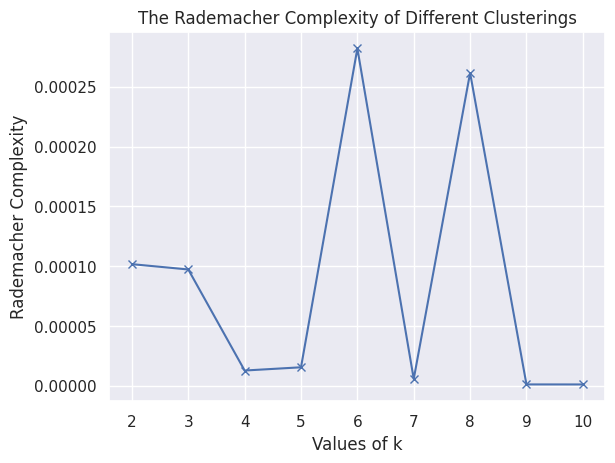

<Figure size 640x480 with 0 Axes>

In [110]:
plt.plot(k, radd, 'bx-')
plt.xlabel('Values of k')
plt.ylabel('Rademacher Complexity')
plt.title('The Rademacher Complexity of Different Clusterings')
plt.show()
plt.savefig("Rademacher.svg")